# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. Monte Carlo simulation
### With a realistic beam spectrum and taking into account the energy response of the detector
#### Authors: T. Wen, A. Sujar and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to real images from the [Visible Human Project (VHP)](https://www.nlm.nih.gov/research/visible/visible_human.html). We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** <!--We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).-->

<!-- In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic and the energy response of the detector is considered.
 -->
<!-- ![Geometric parameters](doc/setup.png)
 -->
<!--The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density.--> We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). <!--The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).-->

![Sample composition](plots/VHP_model.png)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE ????%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is ????%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.????**. 
As MAPE is low (close to 0), SSIM is 0.???, and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

## Import packages

In [1]:
%matplotlib inline

import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
# from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tifffile import imread, imsave # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

import k3d
import random
import base64
import stl

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook
import cma # Optimisation
import sys

SimpleGVXR 1.0.1 (2021-11-23T22:14:20) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-11-23T22:14:19) [Compiler: GNU g++] on Linux


In [2]:
def standardisation(img):
    return (img - img.mean()) / img.std()

## Reference image

We first load the reference image from the [Visible Human Project](https://www.nlm.nih.gov/databases/download/vhp.html). You can find it at [https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z](https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z). When you download it, make sure to gunzip it!

In [3]:
Image = np.fromfile("VHP/x_vm_pe", dtype=np.uint8)
Image.shape = (1536,1248)
Image = np.rot90(Image)

In [4]:
imsave('gVirtualXRay_output_data/real_projection-VHP.tif', Image.astype(np.single))

In [5]:
raw_reference = Image.astype(np.single) / 255.0

In [6]:
imsave('gVirtualXRay_output_data/corrected_real_projection-VHP.tif', raw_reference.astype(np.single))

We plot the image using a linear look-up table and a power-law normalisation.

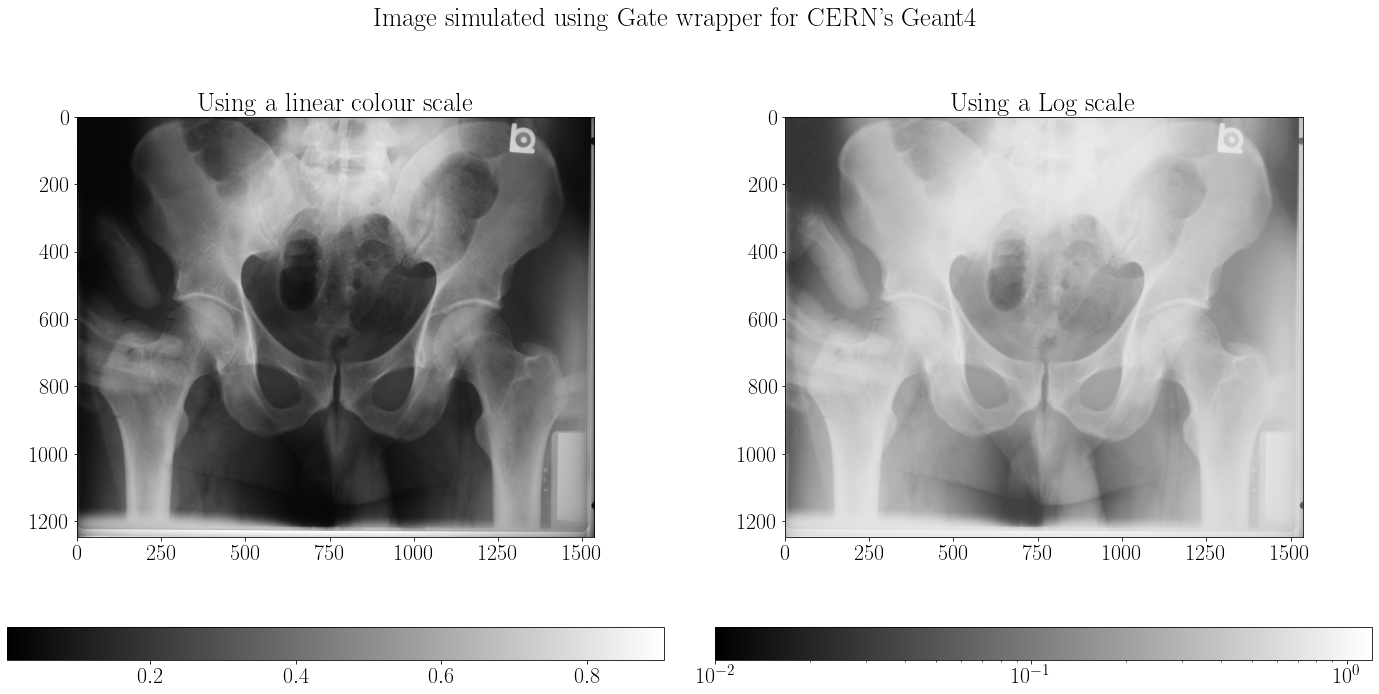

In [7]:
displayLinearPowerScales(raw_reference,
                         "Image simulated using Gate wrapper for CERN's Geant4",
                         "plots/reference_from_Gate-VHP",
                         log=True)

Apply a log transformation

In [8]:
ground_truth = raw_reference
log_ground_truth = np.log(ground_truth)
ground_truth = standardisation(log_ground_truth)

imsave('gVirtualXRay_output_data/ground_truth-VHP.tif', ground_truth.astype(np.single))

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [9]:
json2gvxr.initGVXR("notebook-8.json", "OPENGL")

Create an OpenGL context: 800x450


## X-ray source

We create an X-ray source. It is a point source.

In [10]:
json2gvxr.initSourceGeometry("notebook-8.json")

Set up the beam
	Source position: [0.0, -16.5, 150.0, 'cm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [11]:
spectrum, unit, k, f = json2gvxr.initSpectrum("notebook-8.json", verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

params["Source"]["Beam"] {'kvp': 85, 'tube angle': 12, 'filter': [['Al', 3.2]]}
['Al', 3.2]


Plot the spectrum

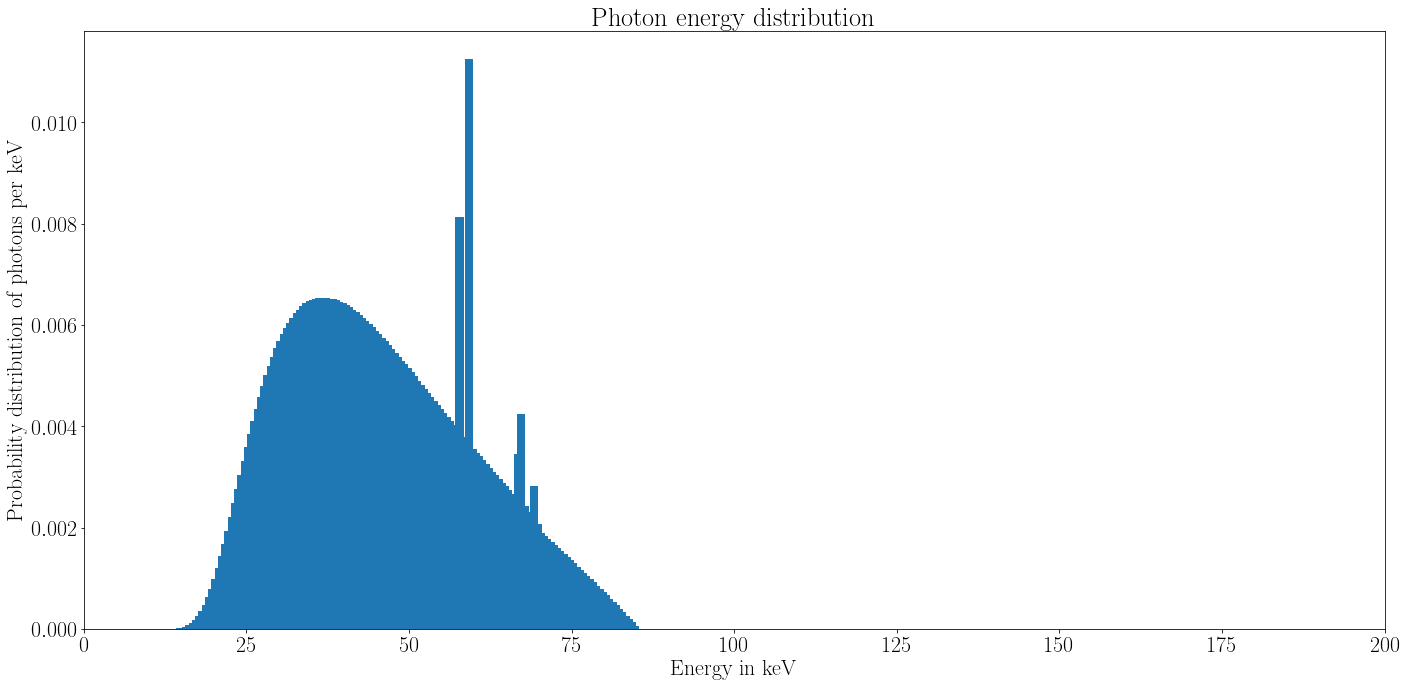

In [12]:
plotSpectrum(k, f, 'plots/spectrum-VHP')

## Detector

Create a digital detector

In [13]:
json2gvxr.initDetector("notebook-8.json")

Set up the detector
	Detector position: [0.0, -16.5, -12.5, 'cm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [1536, 1248]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [0.026347682927083334, 0.026347683, 'cm']


## Model the energy response of the detector

Load the energy response

In [14]:
detector_response = np.loadtxt("Gate_data/responseDetector.txt")

Display the energy response

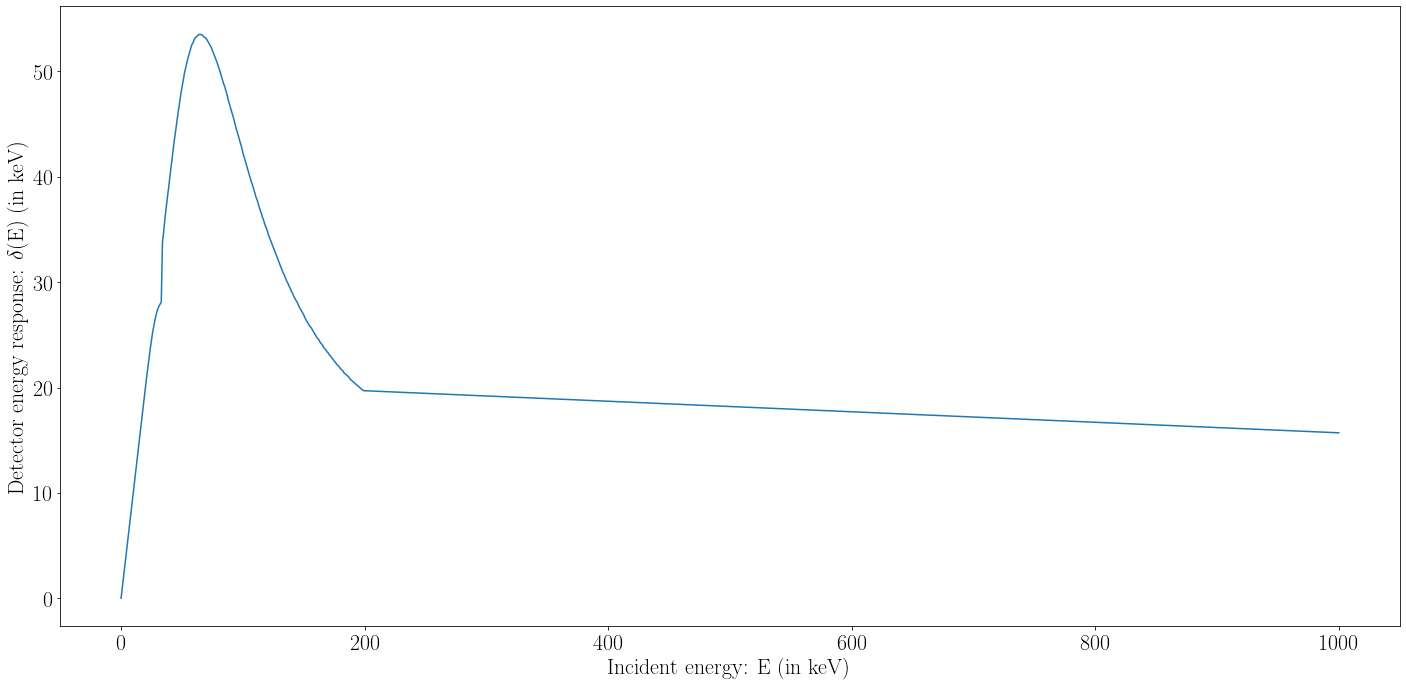

In [15]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

plt.savefig('plots/detector_response-VHP.pdf')
plt.savefig('plots/detector_response-VHP.png')

## Sample

We now load the models segmented from the Visible Human.

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [16]:
json2gvxr.initSamples(verbose=0)

# Apply the scaling factor from pixels to cm

In [17]:
for mesh in json2gvxr.params["Samples"]:
    label = mesh["Label"]
    gvxr.scaleNode(label, 3.3, 3.3, 3.3)
    gvxr.applyCurrentLocalTransformation(label)

Visualise the virtual patient

## Registration of the patient, source and detector

The SSD, DOD and rotation of the virtual patient are unknown. We estimate them to register a simulated X-ray image on a real radiograph.

In [18]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

    total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [19]:
# Function to update source and detector position
def updateSourceAndDetectorPosition(x, y, SOD, DOD):
        
    # Update source position
    source_position = [x, y, SOD, "cm"]
    gvxr.setSourcePosition(
        source_position[0],
        source_position[1],
        source_position[2],
        source_position[3]
    )

    # Update detector position
    detector_position = [x, y, -DOD, "cm"]
    gvxr.setDetectorPosition(
        detector_position[0],
        detector_position[1],
        detector_position[2],
        detector_position[3]
    )

# function to compute X-Ray image and reset rotation
def computeXRayImageAndResetGeometry(anAngleX, anAngleY):
    
    
    matrix = gvxr.getSceneTransformationMatrix()
    
    gvxr.rotateScene(anAngleX, 1, 0, 0)
    gvxr.rotateScene(anAngleY, 0, 1, 0)
    
    image = np.array(gvxr.computeXRayImage())
    
    gvxr.setSceneTransformationMatrix(matrix)

    return image

def zncc(y_true, y_pred):
    """
    Zero-mean Normalised Cross Correlation.
    ZNCC = (1/n)*(1/(std(target_image)*std(est_image)))* SUM_n_by_n{(target_image-
            mean(target_image))*(est_image-mean(est_image))}
    @Parameters:
        y_true: ground truth or target image
        y_pred: predicted image
    """
    z = np.sum((y_true-y_true.mean())*(y_pred-y_pred.mean()))

    z /= -(y_true.shape[0]*y_true.shape[1]*y_true.std()*y_pred.std())
    if np.isnan(z)==True or np.isinf(z)==True:
        z = 0.

    return z


In [20]:
y_max = 1000
roi_ground_truth = standardisation(log_ground_truth[:y_max])

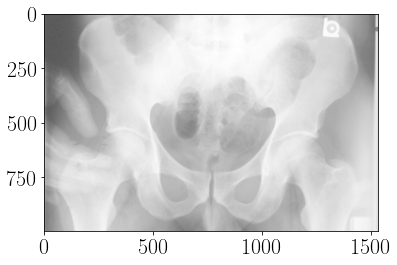

In [21]:
plt.imshow(roi_ground_truth, cmap="gray")
ground_truth = roi_ground_truth

In [22]:
# Define objective function
def objectiveFunction(x):
    
    global total_energy_in_MeV
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_zncc, evolution_parameters
    
    SOD = x[0] 
    DOD = x[1]
    rotation_angle_x = x[2]
    rotation_angle_y = x[3]
    
    x_pos = x[4]
    y_pos = x[5]
    
    # set up source and detector position
    updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)
    
    # compute X-Ray image and reset rotation
    x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
    x_ray_image = x_ray_image[:y_max]
    
    # Flat-field
    x_ray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
    # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()
    
    # Brightness/contrast
    # x_ray_image += shift
    # x_ray_image *= scale
    
    
    ## MIRROR THE PICTURE!!!
    x_ray_image = np.flip(x_ray_image, 1)
    
    x_ray_image = standardisation(x_ray_image)
    
    # objective = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
    objective = np.abs(ground_truth - x_ray_image).mean()
    
#     objective = mape(ground_truth, x_ray_image)
#     objective = -ssim(ground_truth, x_ray_image, data_range=(ground_truth.max() - ground_truth.min()))
#     objective = zncc(ground_truth, x_ray_image)
    if best_fitness > objective:
        
        gvxr.displayScene()
        screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

        imsave("gVirtualXRay_output_data/HIPS_xray_" + str(best_fitness_id) + ".tif", x_ray_image.astype(np.single))
        imsave("gVirtualXRay_output_data/HIPS_screenshot_" + str(best_fitness_id) + ".tif", screenshot)
    
        zncc_value = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image - x_ray_image.mean()) / x_ray_image.std())
        evolution_zncc.append([fitness_function_call_id, zncc_value])
        evolution_parameters.append([fitness_function_call_id, SOD, DOD, rotation_angle_x, rotation_angle_y,x_pos, y_pos])
        
        best_fitness = objective
        best_fitness_id += 1
    
    fitness_function_call_id += 1
   
    return objective

Compute the SOD and DOD

In [23]:
source_position = gvxr.getSourcePosition("cm")
detector_position = gvxr.getDetectorPosition("cm")

source_accumulator = 0.0
detector_accumulator = 0.0

for i, j in zip(source_position, detector_position):
    if i != j:
        source_accumulator += i * i
        detector_accumulator += j * j

SOD = math.sqrt(source_accumulator)

DOD = math.sqrt(detector_accumulator)

print("SOD:", SOD)
print("DOD:", DOD)

SOD: 150.0
DOD: 12.5


In [24]:
SOD = 150.0
DOD = 12.5

x_init = [SOD, 40, 0, 0, 0, -35]

SOD = x_init[0] 
DOD = x_init[1]
rotation_angle_x = x_init[2]
rotation_angle_y = x_init[3]

x_pos = x_init[4]
y_pos = x_init[5]

# set up source and detector position
updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# compute X-Ray image and reset rotation
x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
x_ray_image = x_ray_image[:y_max]
imsave('gVirtualXRay_output_data/temp.tif', x_ray_image.astype(np.single))

# Flat-field
x_ray_image /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
x_ray_image = np.ones(x_ray_image.shape) - x_ray_image

x_ray_image = standardisation(x_ray_image)

imsave('gVirtualXRay_output_data/x_ray_image-VHP.tif', x_ray_image.astype(np.single))

mirrored_image = np.flip(x_ray_image, 1)

imsave('gVirtualXRay_output_data/mirrored_image-VHP.tif', mirrored_image.astype(np.single))


In [25]:
gvxr.displayScene()
gvxr.setZoom(1834.34326171875)
gvxr.setSceneRotationMatrix([
        0.7077475786209106,   -0.021133223548531532, -0.7061462998390198,  0.0,
       -0.0030647937674075365, 0.9994487762451172,   -0.03298407047986984, 0.0,
        0.7064606547355652,    0.025507455691695213,  0.7072934508323669,  0.0,
        0.0,                   0.0,                   0.0,                 1.0
    ])

gvxr.enableArtefactFilteringOnGPU()
gvxr.useNegative()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()

gvxr.displayScene()

In [26]:
# gvxr.renderLoop()
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

image = np.array(gvxr.computeXRayImage())
imsave('gVirtualXRay_output_data/temp.tif', image.astype(np.single))

In [27]:
if False: #os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
    SOD, DOD, rotation_angle_x, rotation_angle_y,x_pos, y_pos = np.loadtxt("gVirtualXRay_output_data/HIPS.dat")
    evolution_zncc = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat")
    evolution_parameters = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat")

# CMA-ES
else:

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-6)
    opts['tolx'] = 1e-2
    opts['bounds'] = [[SOD * 0.7, -100, -20, -20, -20, -50],
                      [SOD * 1.3, 100, 20,  20,  20,  50]]

    opts['CMA_stds'] = []

    rotation_angle_x = 0.0
    rotation_angle_y = 0.0

    # shift = 0.0
    # scale = 1.0
    # -5.0, 0.0
    # 5.0, 5.0

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.15)

    best_fitness = sys.float_info.max
    best_fitness_id = 0
    fitness_function_call_id = 0
    evolution_zncc = []
    evolution_parameters = []

    res = cma.fmin(objectiveFunction,
              x_init,
              0.5,
              opts,
              restarts=1)
    SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos = res[0]


    # Save best parameters from the optimiser
    np.savetxt("gVirtualXRay_output_data/HIPS.dat", [SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos], header='SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos')

    # Save the list of zncc for plotting
    evolution_zncc = np.array(evolution_zncc)
    np.savetxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat", evolution_zncc, header='t,ZNCC')

    # Save the list of parameters for plotting
    evolution_parameters = np.array(evolution_parameters)
    np.savetxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat", evolution_parameters, header='t,SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos')

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1042627, Wed Dec  8 14:54:25 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.007068398328180e-01 1.0e+00 4.42e-01  3e+00  1e+01 0:04.1
    2     18 6.132670060998908e-01 1.1e+00 3.90e-01  2e+00  1e+01 0:07.7
    3     27 5.985241588082073e-01 1.1e+00 3.58e-01  2e+00  1e+01 0:11.6
    4     36 6.225080770637724e-01 1.2e+00 3.04e-01  2e+00  8e+00 0:15.3
    6     54 6.233073187260959e-01 1.5e+00 2.34e-01  1e+00  6e+00 0:22.5
    8     72 5.665314950636051e-01 1.7e+00 2.80e-01  1e+00  9e+00 0:30.1
   10     90 5.670422620850182e-01 1.9e+00 3.50e-01  2e+00  1e+01 0:37.3
   12    108 6.021112715312614e-01 2.3e+00 3.54e-01  1e+00  1e+01 0:44.7
   15    135 5.433623751602297e-01 2.6e+00 2.57e-01  9e-01  7e+00 0:55.7
   18    162 5.496215462541943e-01 2.6e+00 1.80e-01  6e-01  5e+00 1:06.5
   21    189 5.504876554681352e-01 2.7e+00 1.62e-01  4e-01  4e+00 1:17.9
   24    216 5.382639374346802e-01

In [28]:
# set up source and detector position
updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

gvxr.rotateScene(rotation_angle_x, 1, 0, 0)
gvxr.rotateScene(rotation_angle_y, 0, 1, 0)

In [35]:
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering()
x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = x_ray_image[:y_max]
x_ray_image = standardisation(x_ray_image)
gvxr.displayScene()

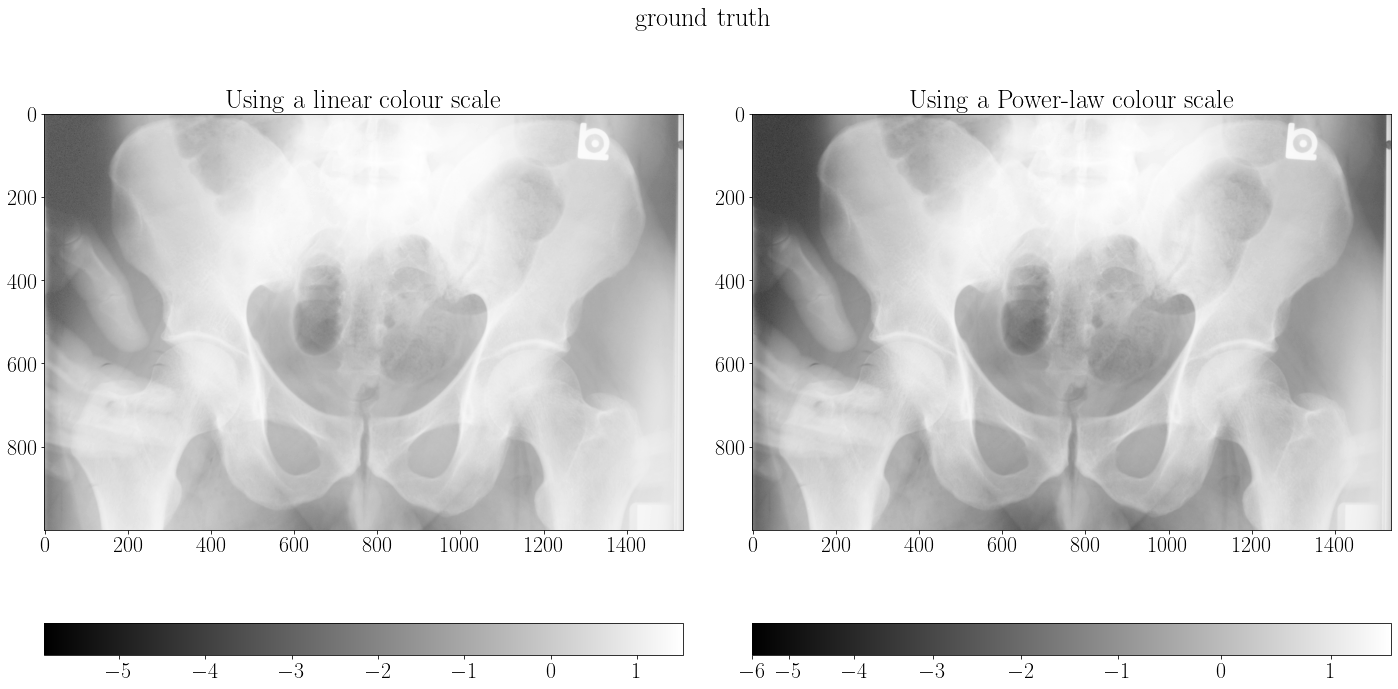

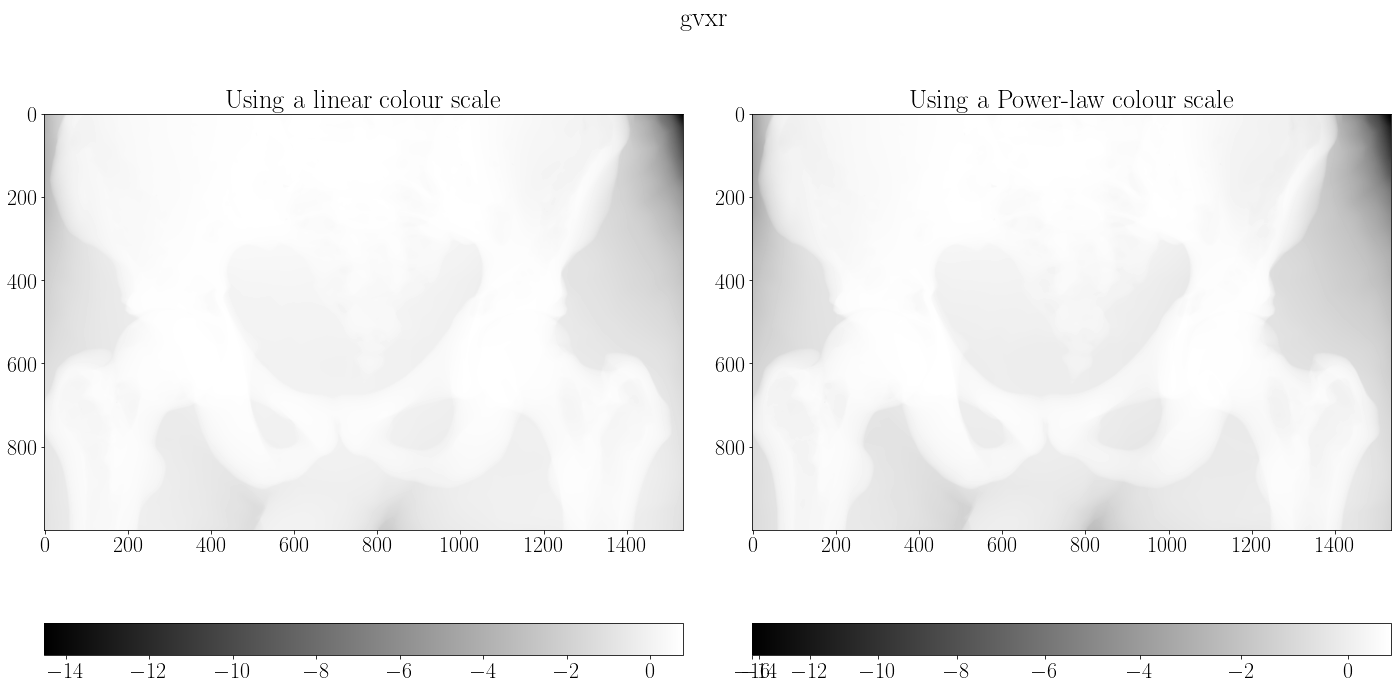

In [37]:
max_value = max(-ground_truth.min(), ground_truth.max())
displayLinearPowerScales(ground_truth, "ground truth", "temp", vmin=-max_value, vmax=max_value)

max_value = max(-x_ray_image.min(), x_ray_image.max())
displayLinearPowerScales(-x_ray_image, "gvxr", "temp", vmin=-max_value, vmax=max_value)

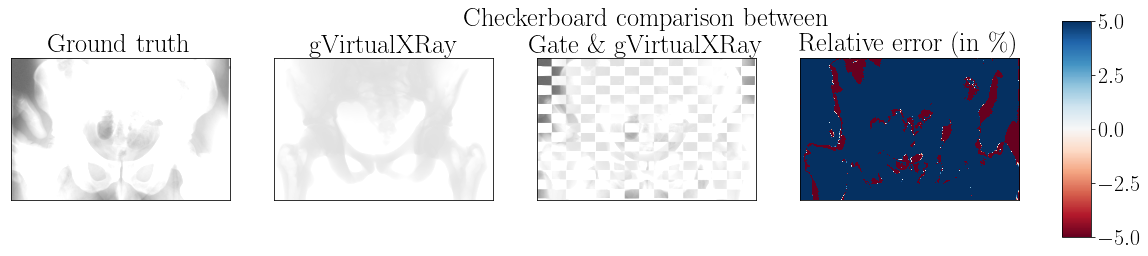

In [31]:
fullCompareImages(log_ground_truth, standardisation(x_ray_image[:y_max]),
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-VHP',
               vmin=log_ground_truth.min(), vmax=log_ground_truth.max())

## Registration for image processing (shift and scale)
Optimising image brightness/contrast

In [38]:
# # set up source and detector position
# updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# gvxr.rotateScene(rotation_angle_x, 1, 0, 0)
# gvxr.rotateScene(rotation_angle_y, 0, 1, 0)

In [39]:
# gvxr.enableArtefactFilteringOnGPU()
# # gvxr.disableArtefactFiltering()
# x_ray_image = standardisation(-np.array(gvxr.computeXRayImage()))
# gvxr.displayScene()

In [40]:
# gvxr.renderLoop()
# plt.imshow(x_ray_image, cmap="gray")

In [41]:
# max_value = max(-ground_truth.min(), ground_truth.max())
# displayLinearPowerScales(ground_truth, "ground truth", "temp", vmin=-max_value, vmax=max_value)

# max_value = max(-x_ray_image.min(), x_ray_image.max())
# displayLinearPowerScales(x_ray_image, "gvxr", "temp", vmin=-max_value, vmax=max_value)

In [43]:
# fullCompareImages(ground_truth, standardisation(x_ray_image[:y_max]),
#               "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
#               'plots/comparison_integration_GPU-VHP',
#                vmin=log_ground_truth.min(), vmax=log_ground_truth.max())
log_ground_truth = log_ground_truth[:y_max]

In [44]:
x_ray_image = np.array(gvxr.computeXRayImage())

def objectiveFunctionImageProcessing(x):
    
    global total_energy_in_MeV, log_ground_truth, x_ray_image
    
    shift1 = x[0]
    scale1 = x[1]
    shift2 = x[2]
    scale2 = x[3]
        
    temp = np.copy(x_ray_image[:y_max])
    
    # Flat-field
    temp /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    temp = np.ones(temp.shape) - temp
    # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()
    
    
    # Brightness/contrast
    temp = ((temp + shift1) * scale1 + shift2) * scale2

    # x_ray_image += shift
    # x_ray_image *= scale
    
    ## MIRROR THE PICTURE!!!
    temp = np.flip(temp, 1)
    
    

    # x_ray_image = standardisation(x_ray_image)

    objective = math.sqrt(mean_squared_error(log_ground_truth, temp))
    # objective = mape(log_ground_truth, temp)
    # objective = -ssim(log_ground_truth, temp, data_range=(log_ground_truth.max() - log_ground_truth.min()))
    # objective = zncc(log_ground_truth, temp)
    
    return objective

In [45]:

opts = cma.CMAOptions()
opts.set('tolfun', 1e-6)
opts['tolx'] = 1e-2
opts['bounds'] = [[-150.0, -150.0, -150.0, -150.0],
                  [150.0, 150.0, 150.0, 150.0]]

opts['CMA_stds'] = []

shift1 = 0.0
scale1 = 1.0
shift2 = 0.0
scale2 = 1.0


for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
    opts['CMA_stds'].append(abs(max_val - min_val) * 0.15)

best_fitness = sys.float_info.max
best_fitness_id = 0
fitness_function_call_id = 0
evolution_zncc = []
evolution_parameters = []

res = cma.fmin(objectiveFunctionImageProcessing,
          [shift1, scale1, shift2, scale2],
          0.5,
          opts,
          restarts=0)
shift1, scale1, shift2, scale2 = res[0]


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1103796, Wed Dec  8 15:26:07 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.182789581125724e+02 1.0e+00 4.53e-01  2e+01  2e+01 0:03.4
    2     16 8.660776929080099e+01 1.3e+00 3.97e-01  2e+01  2e+01 0:06.6
    3     24 1.625989083737955e+02 1.4e+00 3.76e-01  1e+01  2e+01 0:09.8
    4     32 6.237416331599912e+00 1.4e+00 3.77e-01  1e+01  2e+01 0:12.9
    6     48 2.918841467487980e+02 1.5e+00 4.47e-01  2e+01  2e+01 0:19.3
    8     64 3.260153698057119e+00 1.5e+00 3.60e-01  1e+01  2e+01 0:25.6
   10     80 1.831682124813517e+01 1.8e+00 3.73e-01  1e+01  2e+01 0:31.9
   13    104 9.718332476186687e+00 2.6e+00 2.75e-01  5e+00  1e+01 0:41.3
   16    128 3.215234116339501e+00 3.8e+00 2.24e-01  3e+00  9e+00 0:50.6
   19    152 1.975163986228474e+00 4.3e+00 2.19e-01  2e+00  9e+00 0:59.9
   23    184 6.875474630821199e+00 5.6e+00 2.17e-01  2e+00  1e+01 1:12.2
   27    216 1.004661708309164e+00

In [46]:
print("SOD (cm):", SOD)
print("DOD (cm):", DOD)
print("Rotation angle x:", rotation_angle_x)
print("Rotation angle y:", rotation_angle_y)
print("Shift1:", shift1)
print("Scale1:", scale1)
print("Shift2:", shift2)
print("Scale2:", scale2)
print("x_pos:", x_pos)
print("y_pos:", y_pos)

SOD (cm): 194.99999415533807
DOD (cm): 25.774504109677647
Rotation angle x: 5.138974388421087
Rotation angle y: 5.528401946535019
Shift1: -2.6153134316623707
Scale1: 89.28495056053681
Shift2: 143.98391365507467
Scale2: 3.7280606529410254
x_pos: -1.0380082951094125
y_pos: -32.572324826145945


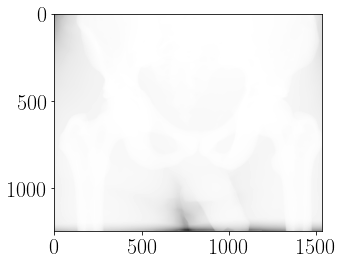

In [47]:
# # set up source and detector position
# updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# # compute X-Ray image and reset rotation
# x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
gvxr.displayScene()

x_ray_image = np.array(gvxr.computeXRayImage())

# Flat-field
x_ray_image /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
# x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()


# Brightness/contrast
x_ray_image = ((x_ray_image + shift1) * scale1 + shift2) * scale2

# x_ray_image += shift
# x_ray_image *= scale

## MIRROR THE PICTURE!!!
x_ray_image = np.flip(x_ray_image, 1)

plt.figure()
plt.imshow(x_ray_image, cmap='gray', vmax=log_ground_truth.max(), vmin=log_ground_truth.min())

plt.figure()
plt.imshow(log_ground_truth, cmap='gray', vmax=log_ground_truth.max(), vmin=log_ground_truth.min())

In [ ]:
# source_position = gvxr.getSourcePosition("cm")
# detector_position = gvxr.getDetectorPosition("cm")

# print(source_position)
# print(detector_position)

In [ ]:
# updateSourceAndDetectorPosition(0, -5, 50.0, 112.5)

In [49]:
if os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
    evolution_zncc = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat")
    evolution_parameters = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat")

evolution_parameters = np.array(evolution_parameters)
evolution_zncc = np.array(evolution_zncc)

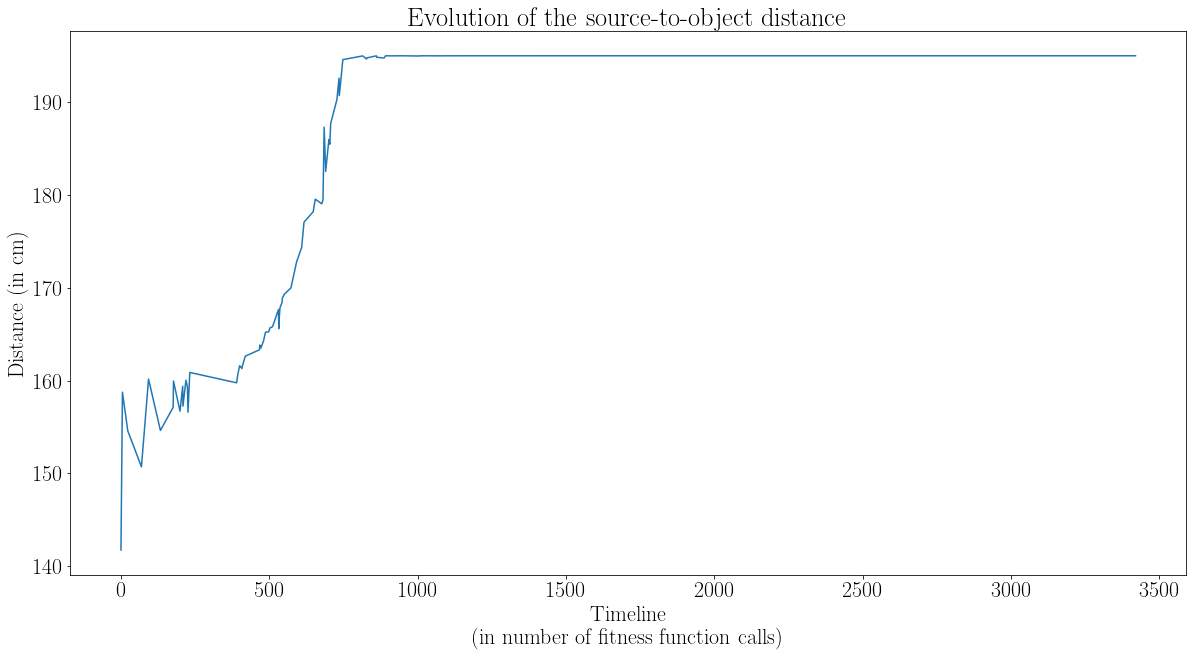

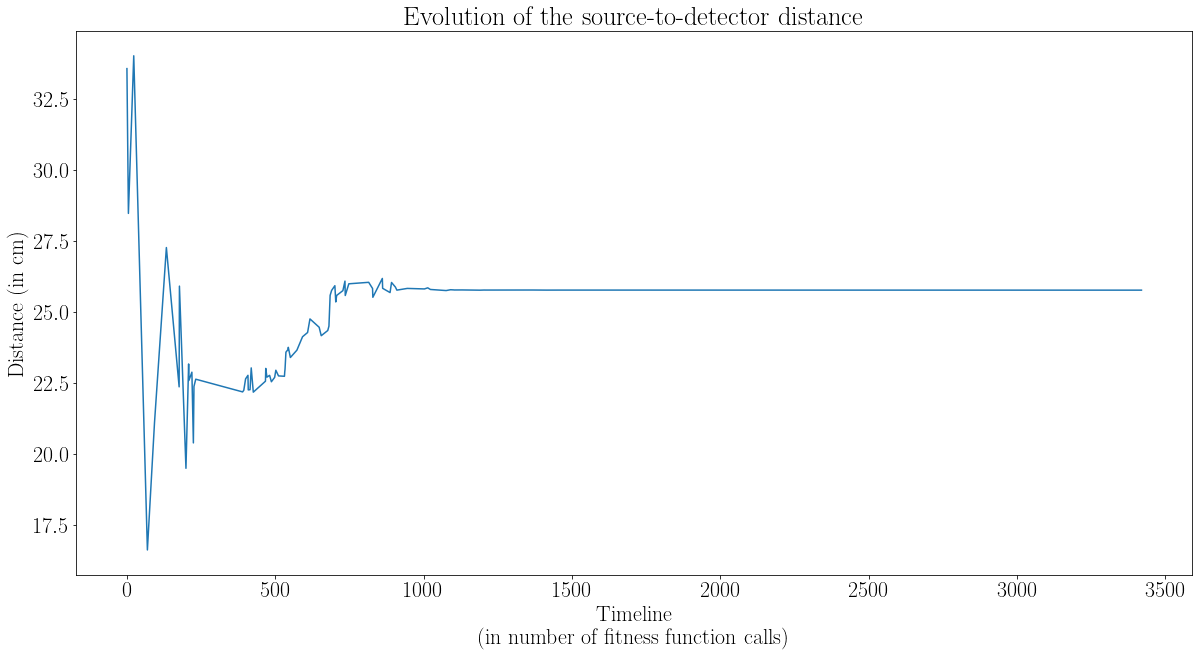

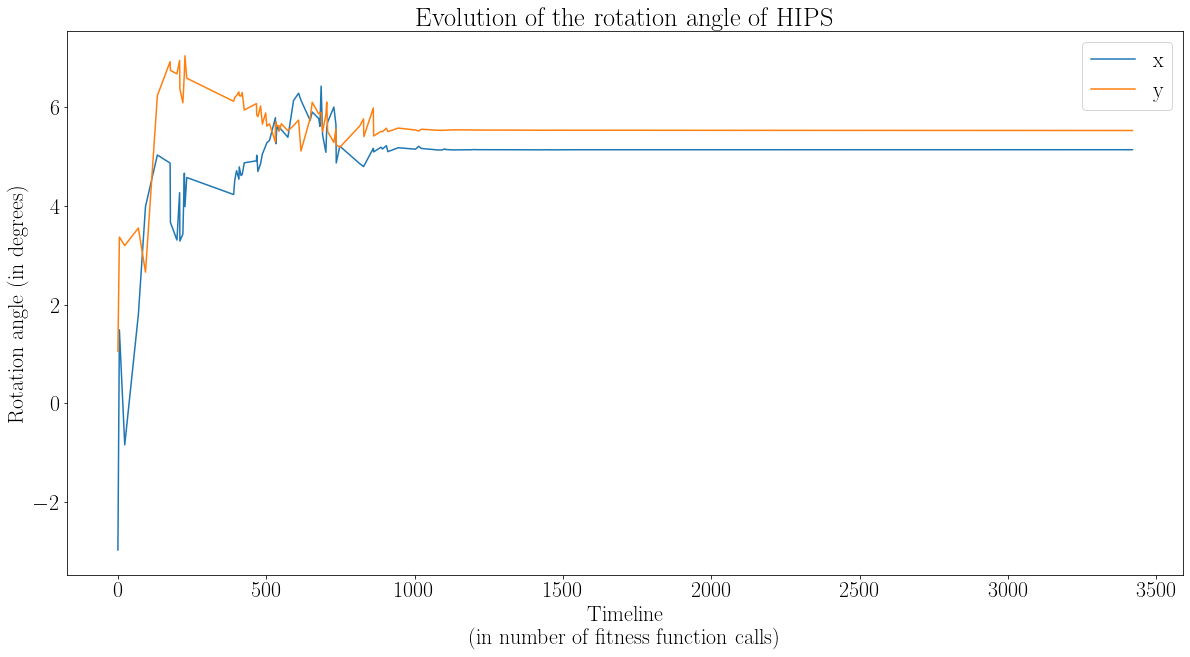

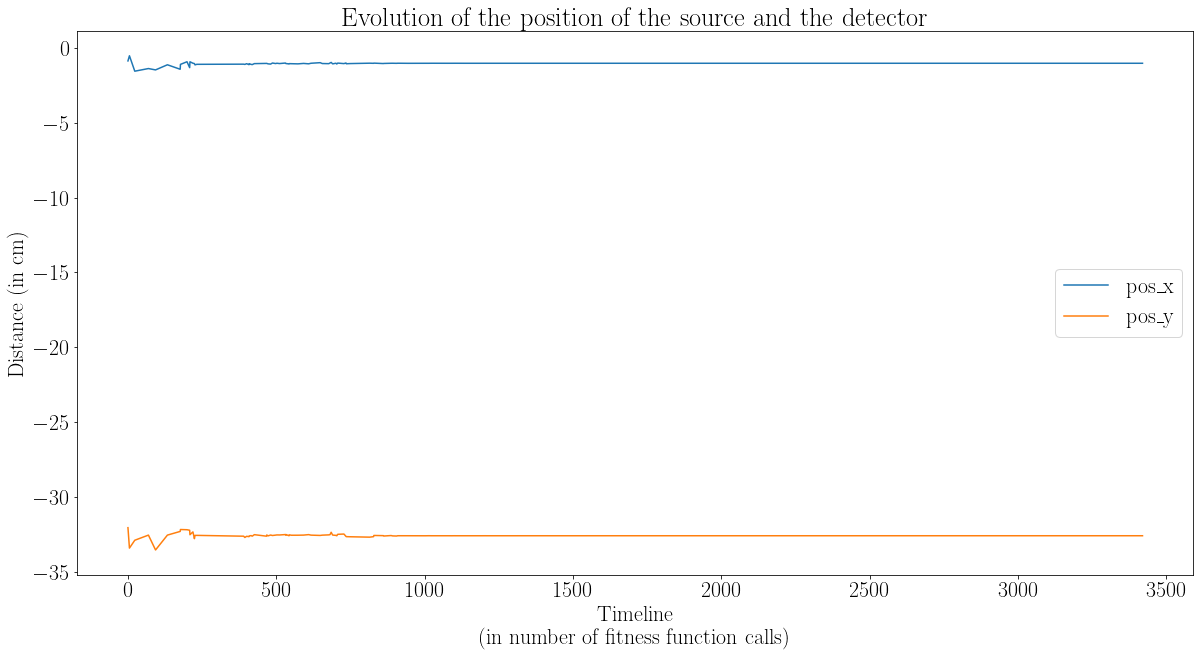

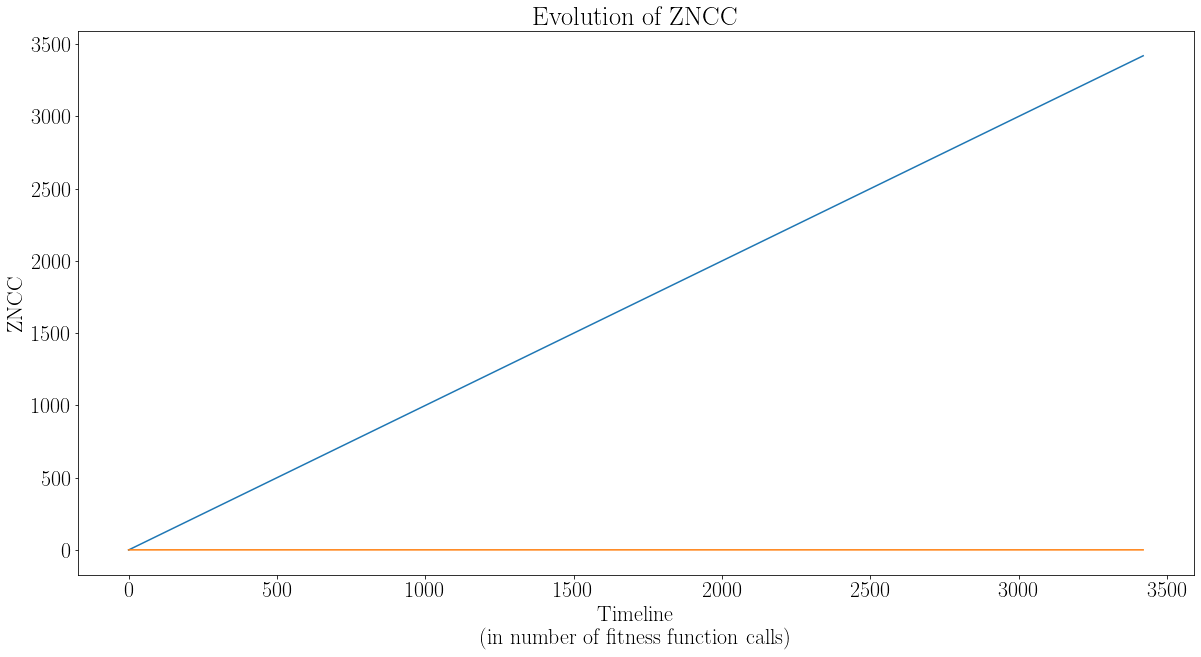

In [50]:

plt.figure(figsize= (20,10))
plt.title("Evolution of the source-to-object distance")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,1])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.savefig('plots/HIPS_evolution_SOD.pdf')
plt.savefig('plots/HIPS_volution_SOD.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the source-to-detector distance")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,2])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.savefig('plots/HIPS_evolution_DOD.pdf')
plt.savefig('plots/HIPS_volution_DOD.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the rotation angle of HIPS")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,3], label="x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,4], label="y")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Rotation angle (in degrees)")
plt.legend()
plt.savefig('plots/HIPS_evolution_angles.pdf')
plt.savefig('plots/HIPS_evolution_angles.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the position of the source and the detector")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,5], label="pos_x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,6], label="pos_y")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.legend()
plt.savefig('plots/HIPS_evolution_pos.pdf')
plt.savefig('plots/HIPS_evolution_pos.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of ZNCC")
plt.plot(evolution_zncc[:,0], evolution_zncc[:,1])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("ZNCC")
plt.savefig('plots/HIPS_evolution_ZNCC.pdf')
plt.savefig('plots/HIPS_volution_ZNCC.png')

# plt.figure(figsize= (20,10))
# plt.title("Evolution of image shift")
# plt.plot(evolution_parameters[:,0], evolution_parameters[:,5])
# plt.xlabel("Timeline\n(in number of fitness function calls)")
# plt.ylabel("shift")
# plt.savefig('plots/HIPS_evolution_shift.pdf')
# plt.savefig('plots/HIPS_evolution_shift.png')

# plt.figure(figsize= (20,10))
# plt.title("Evolution of image scale")
# plt.plot(evolution_parameters[:,0], evolution_parameters[:,6])
# plt.xlabel("Timeline\n(in number of fitness function calls)")
# plt.ylabel("scale")
# plt.savefig('plots/HIPS_evolution_scale.pdf')
# plt.savefig('plots/HIPS_evolution_scale.png')

## NSGA-II 

Optimising position of detector and source, the rotation angle of the object and the brightness/contrast of image.

In [22]:
import pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [23]:
SOD = 150.0

x_init = [150.0, 40, 0, 0, 0, -35, 0.0, 1.0, 0.0, 1.0]


In [24]:
class HIPS(Problem):
    
    def __init__(self):
        xl = np.array([100.0, -100.0, -20.0, -20.0, -20.0, -50.0, -150.0, -150.0, -150.0, -150.0])
        xu = np.array([200.0,  100.0,  20.0,  20.0,  20.0,  50.0,  150.0,  150.0,  150.0,  150.0])
                
        super().__init__(n_var=10, n_obj=2, n_constr=0, xl=xl, xu=xu, type_var=np.float32)

    def _evaluate(self, x, out, *args, **kwargs):
        
        f_list = []
        
        for i in range(len(x[:,0])):
            
            SOD = x[i,0]
            DOD = x[i,1]

            rotation_angle_x = x[i,2]
            rotation_angle_y = x[i,3]

            x_pos = x[i,4]
            y_pos = x[i,5]

            shift1 = x[i,6]
            scale1 = x[i,7]
            shift2 = x[i,8]
            scale2 = x[i,9]

            # set up source and detector position
            updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

            # compute X-Ray image and reset rotation
            x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
            x_ray_image = x_ray_image[:y_max]

            # Flat-field
            x_ray_image /= total_energy_in_MeV

            # Negative
            # x_ray_image = 1.0 - x_ray_image
            x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
            # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()

            # Brightness/contrast
            x_ray_image = ((x_ray_image + shift1) * scale1 + shift2) * scale2

            ## MIRROR THE PICTURE!!!
            x_ray_image = np.flip(x_ray_image, 1)

            x_ray_image = standardisation(x_ray_image)

            # objective = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
            # f1 = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
            f1 = np.abs(ground_truth - x_ray_image).mean()
            f2 = zncc(ground_truth, x_ray_image)
            f_list.append([f1, f2])
            

        out["F"] = np.array(f_list)

In [25]:
gvxr.displayScene()
gvxr.setZoom(1834.34326171875)
gvxr.setSceneRotationMatrix([
        0.7077475786209106,   -0.021133223548531532, -0.7061462998390198,  0.0,
       -0.0030647937674075365, 0.9994487762451172,   -0.03298407047986984, 0.0,
        0.7064606547355652,    0.025507455691695213,  0.7072934508323669,  0.0,
        0.0,                   0.0,                   0.0,                 1.0
    ])

gvxr.enableArtefactFilteringOnGPU()
gvxr.useNegative()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()

gvxr.displayScene()

In [26]:
if False: #os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
    SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos, shift1, scale1, shift2, scale2 = np.loadtxt("gVirtualXRay_output_data/HIPS-NSGA2.dat")
    
    
else:
    
    problem = HIPS()

    algorithm = NSGA2(pop_size=50,
                      eliminate_duplicates=True,
                      x0=x_init,
                      tolfun=1e-6,
                      tolx=1e-4)

    res = minimize(problem,
                   algorithm,
                   ('n_gen', 100),
                   seed=43122,
                   verbose=False)
    SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos, shift1, scale1, shift2, scale2 = res.X[0]
    # Save best parameters from the optimiser
    np.savetxt("gVirtualXRay_output_data/HIPS-NSGA2.dat", [SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos, shift1, scale1, shift2, scale2], header='SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos,shift1,scale1,shift2,scale2')


In [27]:
param = res.X[0]

SOD = param[0]
DOD = param[1]

rotation_angle_x = param[2]
rotation_angle_y = param[3]

x_pos = param[4]
y_pos = param[5]

shift1 = param[6]
scale1 = param[7]
shift2 = param[8]
scale2 = param[9]

updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

gvxr.rotateScene(rotation_angle_x, 1, 0, 0)
gvxr.rotateScene(rotation_angle_y, 0, 1, 0)

x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = x_ray_image[:y_max]

# Flat-field
x_ray_image /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
# x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()

# Brightness/contrast
x_ray_image = ((x_ray_image + shift1) * scale1 + shift2) * scale2

## MIRROR THE PICTURE!!!
x_ray_image = np.flip(x_ray_image, 1)

x_ray_image = standardisation(x_ray_image)

print("SOD (cm):", SOD)
print("DOD (cm):", DOD)
print("Rotation angle x:", rotation_angle_x)
print("Rotation angle y:", rotation_angle_y)
print("Shift1:", shift1)
print("Scale1:", scale1)
print("Shift2:", shift2)
print("Scale2:", scale2)
print("x_pos:", x_pos)
print("y_pos:", y_pos)

SOD (cm): 199.99670634114656
DOD (cm): 37.810315257841175
Rotation angle x: 8.961273035601982
Rotation angle y: 9.054915929973255
Shift1: 18.363785399789432
Scale1: -45.50867628772992
Shift2: 109.52616054964598
Scale2: -128.8256044548907
x_pos: -1.4260697194019265
y_pos: -32.768330655205794


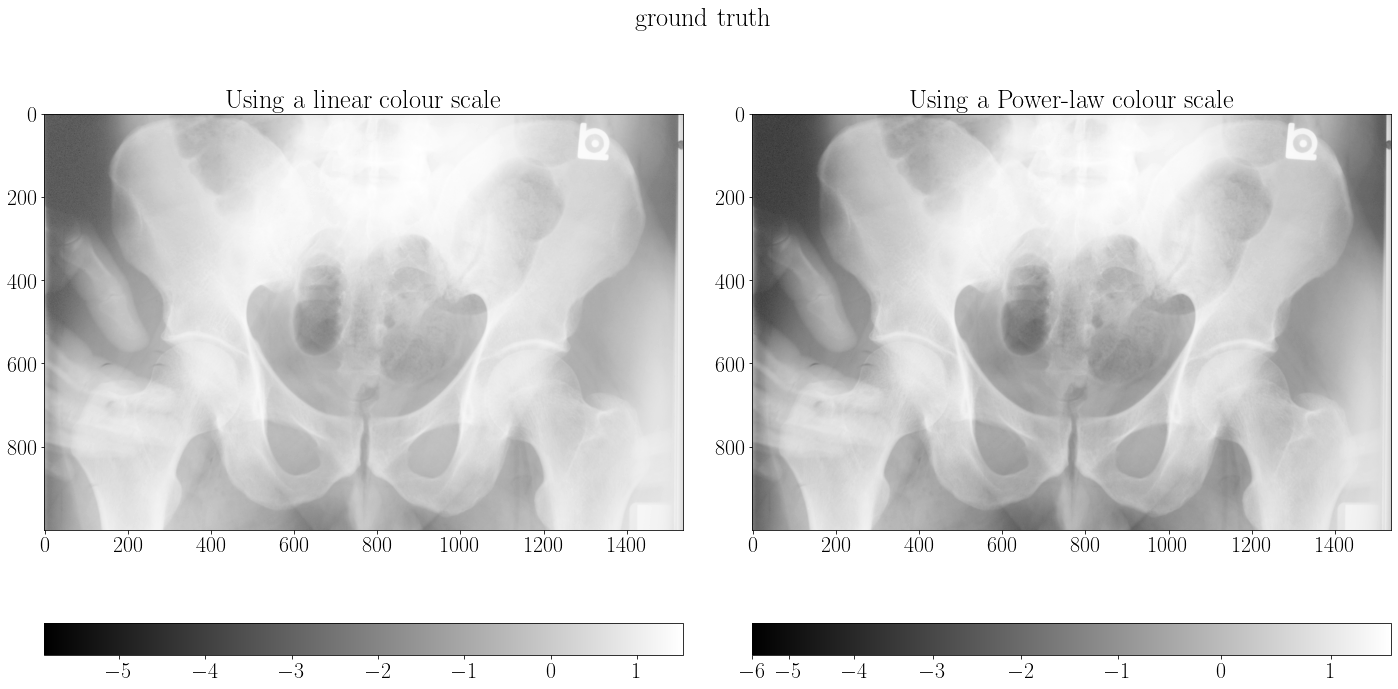

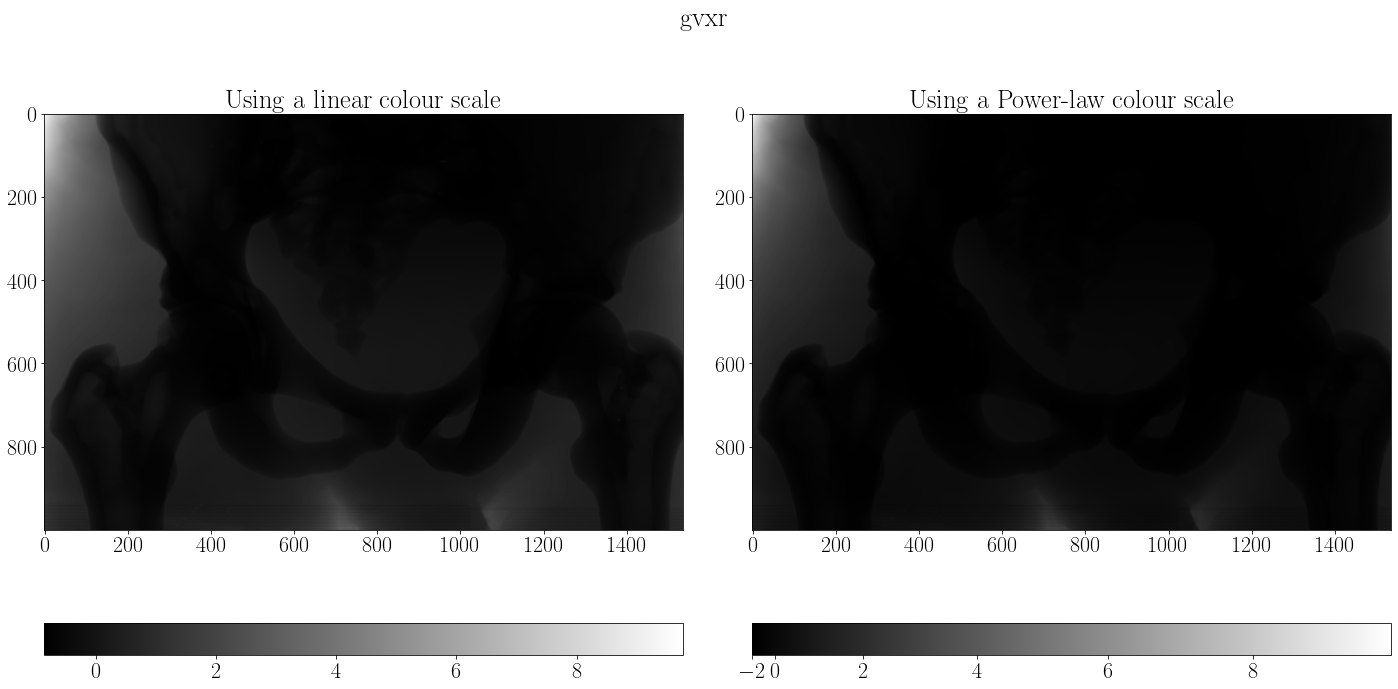

In [28]:
max_value = max(-ground_truth.min(), ground_truth.max())
displayLinearPowerScales(ground_truth, "ground truth", "temp", vmin=-max_value, vmax=max_value)

max_value = max(-x_ray_image.min(), x_ray_image.max())
displayLinearPowerScales(-x_ray_image, "gvxr", "temp", vmin=-max_value, vmax=max_value)

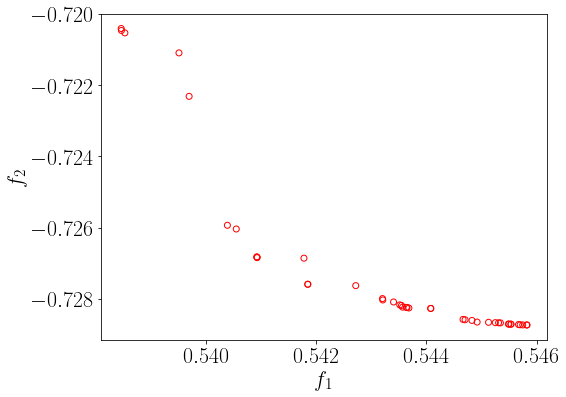

In [29]:
plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [51]:
gvxr.displayScene()
gvxr.enableArtefactFilteringOnGPU()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()
# gvxr.setZoom(419.6787109375)
# gvxr.setSceneRotationMatrix([ 0.46270546317100525, -0.04590693116188049, -0.8853222727775574,  0.0,
#                              -0.0284021757543087,   0.9973739981651306,  -0.06656108051538467, 0.0,
#                               0.8860555291175842,   0.055943090468645096, 0.46018826961517334, 0.0,
#                               0.0,                  0.0,                  0.0,                 1.0])

gvxr.useNegative()
gvxr.displayScene()

In [52]:
screenshot = gvxr.takeScreenshot()

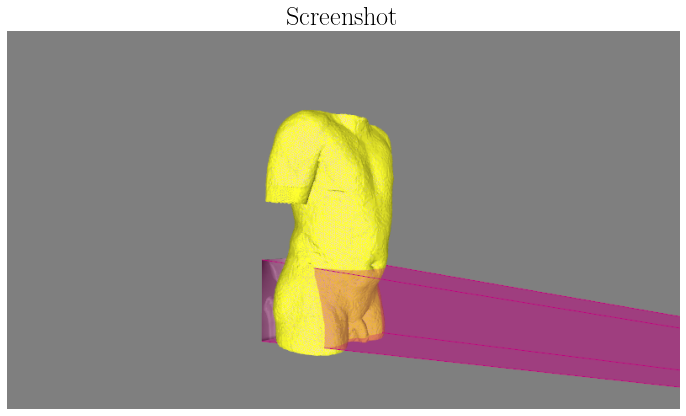

In [53]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-VHP.pdf')
plt.savefig('plots/screenshot-beam-off-VHP.png')

Compute an X-ray image

In [54]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [57]:
# Compute the L-buffers on the GPU and integrate on the CPU
# x_ray_image_integration_CPU = computeXRayImageFromLBuffers(json2gvxr, True, detector_response)

# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
x_ray_image_integration_GPU = x_ray_image_integration_GPU[:y_max]

# Flat-field
# x_ray_image_integration_CPU /= total_energy_in_MeV
x_ray_image_integration_GPU /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
# x_ray_image_integration_CPU = np.ones(x_ray_image_integration_CPU.shape) - x_ray_image_integration_CPU
x_ray_image_integration_GPU = np.ones(x_ray_image_integration_GPU.shape) - x_ray_image_integration_GPU

# Brightness/contrast
x_ray_image_integration_GPU = ((x_ray_image_integration_GPU + shift1) * scale1 + shift2) * scale2

# imsave('gVirtualXRay_output_data/projection_raw_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/projection_raw_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

Normalise the data

In [58]:
ground_truth = standardisation(ground_truth)
# x_ray_image_integration_CPU = standardisation(x_ray_image_integration_CPU)
x_ray_image_integration_GPU = standardisation(x_ray_image_integration_GPU)

In [59]:
print(ground_truth.mean(), ground_truth.std())
# print(x_ray_image_integration_CPU.mean(), x_ray_image_integration_CPU.std())
print(x_ray_image_integration_GPU.mean(), x_ray_image_integration_GPU.std())

-1.7484028e-08 1.0
2.2965333338712904e-15 1.0000000000000007


Flip the image

Save the corresponding image

In [60]:
# imsave('gVirtualXRay_output_data/projection_corrected_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/projection_corrected_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

In [61]:
# displayLinearPowerScales(x_ray_image_integration_CPU,
#                          "Image simulated using gVirtualXRay,\nintegration on CPU",
#                          'plots/x_ray_image_integration_CPU-VHP')

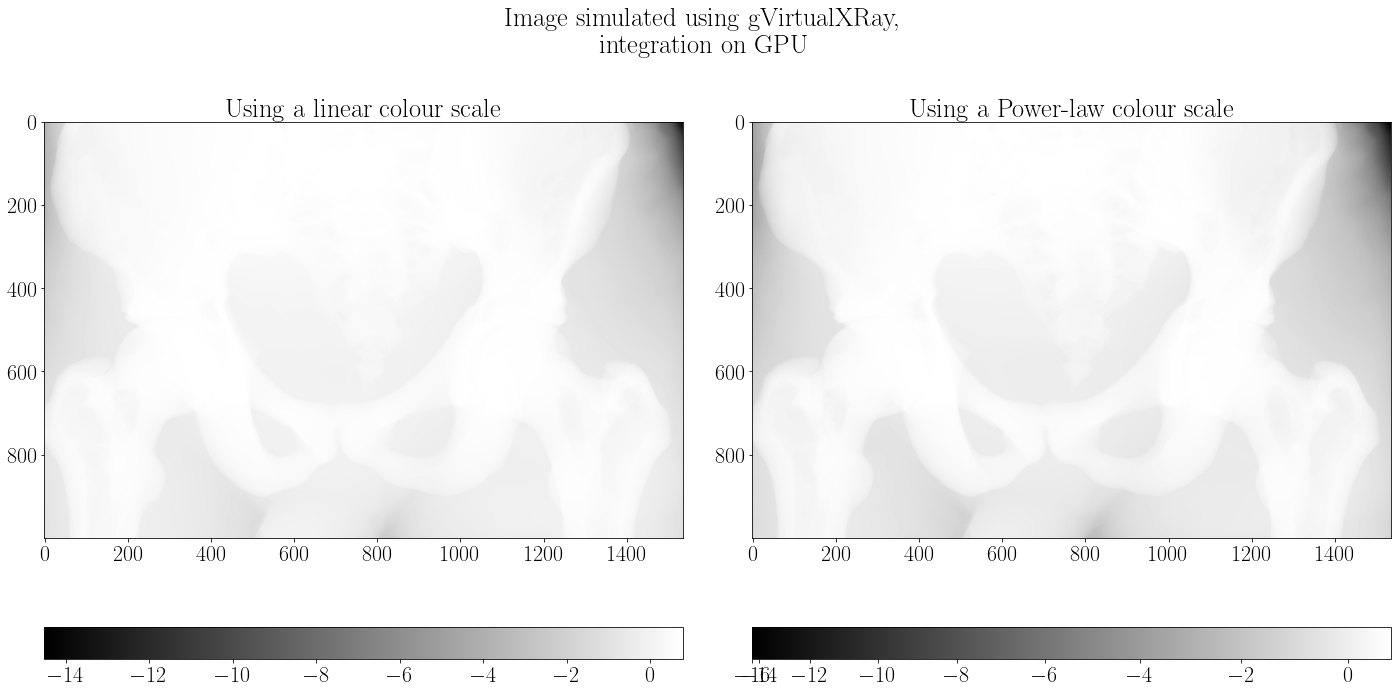

In [62]:
displayLinearPowerScales(x_ray_image_integration_GPU,
                         "Image simulated using gVirtualXRay,\nintegration on GPU",
                         'plots/x_ray_image_integration_GPU-VHP')

Compare the manual implementation with gvxr's

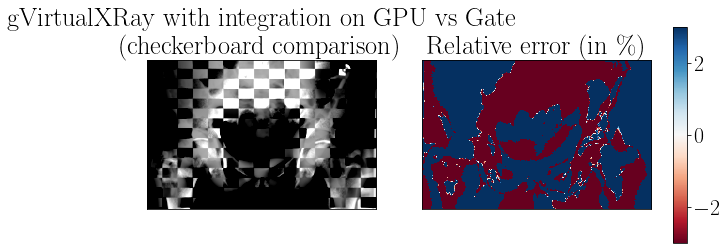

In [63]:
# compareImages(x_ray_image_integration_CPU, ground_truth,
#               "gVirtualXRay with integration on CPU vs Gate\n(checkerboard comparison)",
#               'plots/comparison_integration_CPU-VHP')

compareImages(x_ray_image_integration_GPU, ground_truth,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-VHP')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [64]:
# MAPE_integration_CPU = mape(ground_truth, x_ray_image_integration_CPU)
# ZNCC_integration_CPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_CPU - x_ray_image_integration_CPU.mean()) / x_ray_image_integration_CPU.std())
# SSIM_integration_CPU = ssim(ground_truth, x_ray_image_integration_CPU, data_range=ground_truth.max() - ground_truth.min())


# print("MAPE_integration_CPU:", "{0:0.2f}".format(100 * MAPE_integration_CPU) + "%")
# print("ZNCC_integration_CPU:", "{0:0.2f}".format(100 * ZNCC_integration_CPU) + "%")
# print("SSIM_integration_CPU:", "{0:0.2f}".format(SSIM_integration_CPU))

MAPE_integration_GPU = mape(ground_truth, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(ground_truth, x_ray_image_integration_GPU, data_range=ground_truth.max() - ground_truth.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

MAPE_integration_GPU: 222.85%
ZNCC_integration_GPU: 46.32%
SSIM_integration_GPU: 0.36


In both cases, MAPE is very small (less than 1%) and ZNCC is very high (more than 99%). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

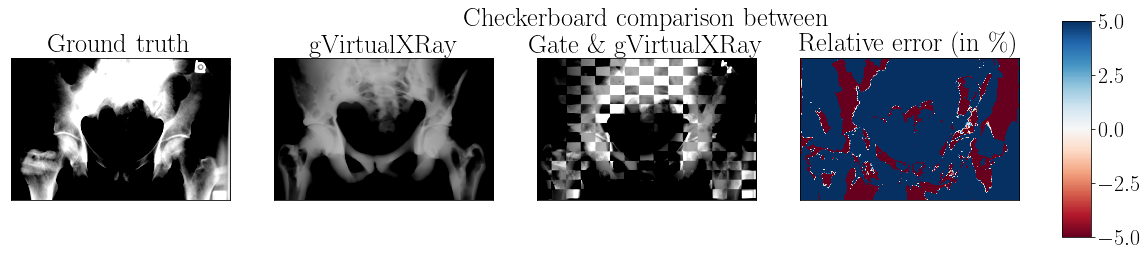

In [65]:
# fullCompareImages(ground_truth,
#                   x_ray_image_integration_CPU,
#                   "gVirtualXRay\n with integration on CPU",
#                   "plots/full_comparison_integration_CPU-VHP")

fullCompareImages(ground_truth,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-VHP")

In [66]:
font = {'size'   : 12
       }
matplotlib.rc('font', **font)

Plot the profiles

In [67]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

In [68]:
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-checkerboard-VHP")

In [69]:
# spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]
# min_limit = round(40)
# max_limit = round(512 * spacing - 40)
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-zoom-checkerboard-VHP", [min_limit, max_limit])

## All done

Destroy the window

In [70]:
gvxr.destroyAllWindows()